# Visualizing the Data

Roman Ludwig [](https://orcid.org/0000-0001-9434-328X) (University of Zurich, University Hospital Zurich)  
Yoel Perez Haas (University of Zurich, University Hospital Zurich)  
Jan Unkelbach [](https://orcid.org/0000-0002-4275-990X) (University of Zurich, University Hospital Zurich)

# Contralateral Involvement Stratified by Risk Factors

To motivate our bilateral model extension, we show how the contralateral nodal involvement in the data depends on T-category, the ipsilateral involvement, and midline extension of the primary tumor.

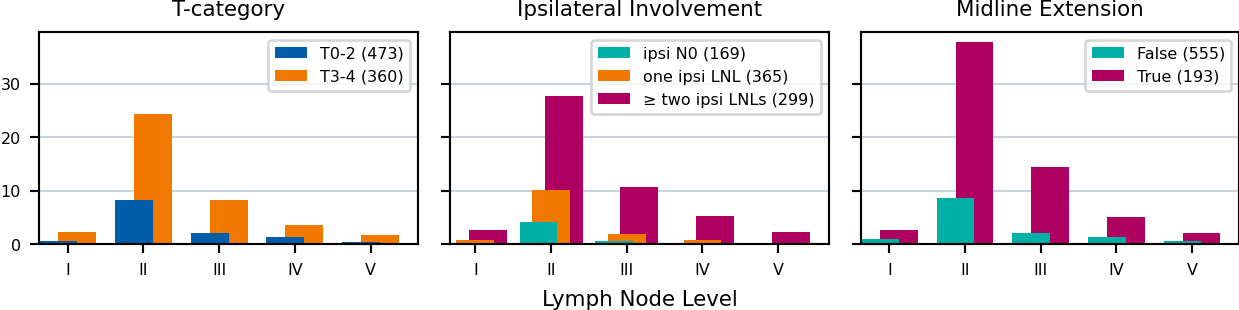

In [1]:
#| label: fig-data-strat
#| fig-cap: 'Contralateral involvement stratified by T-category (left panel), the number of metastatic LNLs ipsilaterally (center panel), and whether the primary tumor extended over the mid-sagittal line or was clearly lateralized (right panel).'
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from lyscripts import utils
from lyscripts.plot.utils import COLORS
from scripts import shared, paths, COL, get_lnl_cols

def group_and_plot(
  df: pd.DataFrame,
  column: str,
  axes: Axes,
  colors: list[str],
) -> None:
  """Group `df` by `column` and plot the result."""
  grouped = df.groupby(by=column)
  counts = grouped.count().T
  aggregated = 100 * grouped.mean().T
  edges = np.linspace(1., 0., len(grouped) + 1)
  positions = edges[1:] + ((edges[0] - edges[1]) / 2)

  for i, ((label, series), (_, count)) in enumerate(zip(
    aggregated.items(),
    counts.items()
  )):
    series.plot(
      ax=axes,
      kind="bar",
      label=f"{label} ({count.iloc[0]})",
      color=colors[i],
      position=positions[i],
      rot=0,
      zorder=2 - i * 0.1
    )

  axes.legend()
  axes.grid(axis="y", color=COLORS["gray"])
  axes.set_axisbelow(True)


nrows, ncols = 1, 3
plt.rcParams.update(**shared.get_fontsizes())
plt.rcParams.update(**shared.get_figsizes(
  nrows=nrows,
  ncols=ncols,
  aspect_ratio=1.1,
))
fig = plt.figure()
gs = gridspec.GridSpec(nrows=nrows, ncols=ncols, figure=fig)

left = fig.add_subplot(gs[0])
center = fig.add_subplot(gs[1], sharey=left)
right = fig.add_subplot(gs[2], sharey=center)
row = fig.add_subplot(gs[:], frame_on=False)

right.set_ylabel("contra prevalence [%]")
right.set_title("Midline Extension")
center.set_title("Ipsilateral Involvement")
left.set_title("T-category")
row.set_xlabel("Lymph Node Level", labelpad=17)
row.set_xticks([])
row.set_yticks([])

raw = utils.load_patient_data(paths.data)
contra_by_midext = raw[[*get_lnl_cols("contra"), COL.midext]].copy()
contra_by_midext.columns = contra_by_midext.columns.droplevel([0,1])

# stratify by midline extension
group_and_plot(
  df=contra_by_midext,
  column="extension",
  axes=right,
  colors=[COLORS["green"], COLORS["red"]],
)

# stratify by ipsilateral involvement
num_ipsi_inv = raw[get_lnl_cols("ipsi")].sum(axis="columns")
contra_by_ipsi = raw[get_lnl_cols("contra")].copy()
contra_by_ipsi.columns = contra_by_ipsi.columns.droplevel([0,1])
contra_by_ipsi["ipsi"] = num_ipsi_inv.map({
  0: "ipsi N0",
  1: "one ipsi LNL",
  2: "≥ two ipsi LNLs",
  3: "≥ two ipsi LNLs",
  4: "≥ two ipsi LNLs",
  5: "≥ two ipsi LNLs",
})

group_and_plot(
  df=contra_by_ipsi,
  column="ipsi",
  axes=center,
  colors=[COLORS["green"], COLORS["orange"], COLORS["red"]],
)

# stratify by T-category
contra_by_t = raw[[*get_lnl_cols("contra"), COL.t_stage]].copy()
contra_by_t.columns = contra_by_t.columns.droplevel([0,1])
contra_by_t["t_stage"] = contra_by_t["t_stage"].map({
  0: "T0-2",
  1: "T0-2",
  2: "T0-2",
  3: "T3-4",
  4: "T3-4",
})

group_and_plot(
  df=contra_by_t,
  column="t_stage",
  axes=left,
  colors=[COLORS["blue"], COLORS["orange"]],
)

plt.savefig(paths.figure_dir / "fig-data-strat.png", dpi=400)
plt.show()

# Involvement Patterns as UpSet Plots

The joint involvement of different combinations of lymphatic involvements is best visualized using so-called *upset plots* \[@lex_upset_2014\].

## Ipsilateral Involvement

/tmp/ipykernel_6448/2479270270.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(paths.figure_dir / "fig-data-upset-ipsi.png", dpi=400)
/home/rmnldwg/repos/bilateral-paper/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)

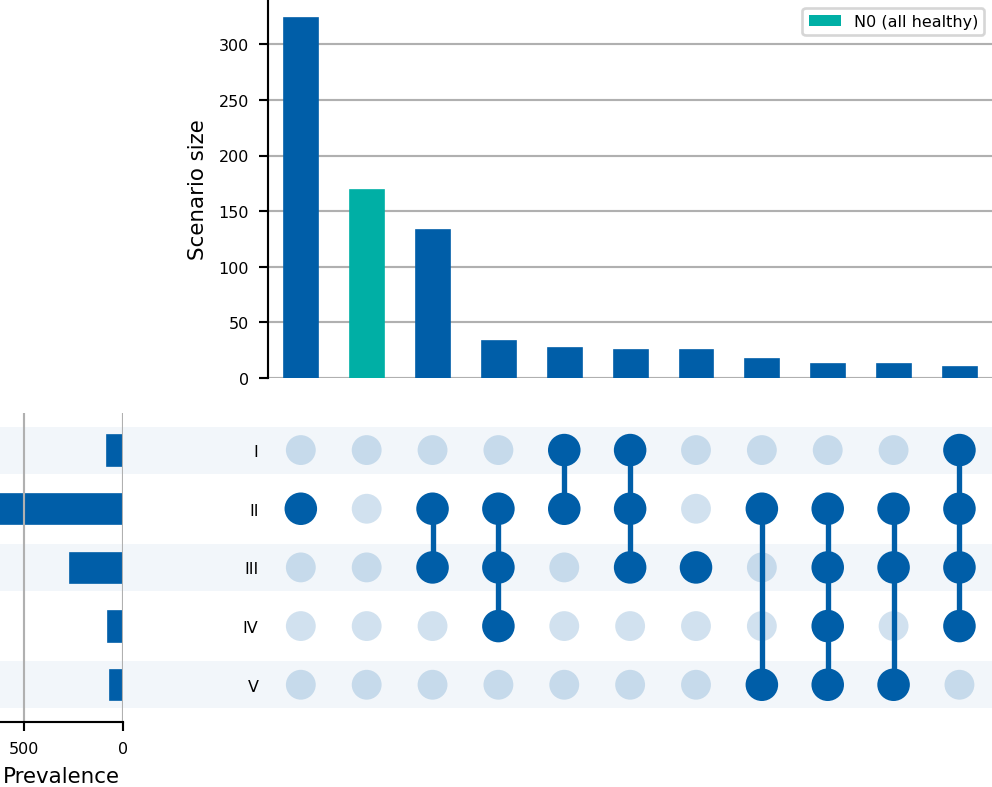

In [2]:
#| label: fig-data-upset-ipsi
#| fig-cap: 'Upset plot of the ipsilateral lymphatic involvement patterns [@lex_upset_2014]. Here, the horizontal bars depict the overall prevalence of LNL involvement. I.e., LNL II is the only level that is involved in more than 500 patients. The vertical bar plots depict joint involvements. E.g., the fourth bar from the left depicts how often the LNLs II, III, and IV are jointly involved while level I and V are not. This is indicated by the light and dark shaded dots in the matrix underneath.'
from typing import Literal
import upsetplot
from scripts import paths

def plot_involvement_upset(
  df: pd.DataFrame,
  lnls: list[str],
) -> Axes:
  """Plot involvement of `side` as upsetplot."""
  indicator_data = upsetplot.from_indicators(
    indicators=lnls,
    data=df,
  )
  upset = upsetplot.UpSet(
    indicator_data,
    sort_by="cardinality",
    sort_categories_by="-input",
    min_subset_size=10,
    facecolor=COLORS["blue"],
  )
  upset.style_subsets(
    absent=lnls,
    facecolor=COLORS["green"],
    label="N0 (all healthy)",
  )
  axes = upset.plot()
  axes["totals"].set_xlabel("Prevalence")
  axes["intersections"].set_ylabel("Scenario size")
  return axes

axes = plot_involvement_upset(
  df=raw["max_llh", "ipsi"],
  lnls=[tpl[-1] for tpl in get_lnl_cols("ipsi")],
)

plt.savefig(paths.figure_dir / "fig-data-upset-ipsi.png", dpi=400)
plt.show()

## Contralateral Involvement

/tmp/ipykernel_6448/3104973063.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(paths.figure_dir / "fig-data-upset-contra.png", dpi=400)
/home/rmnldwg/repos/bilateral-paper/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)

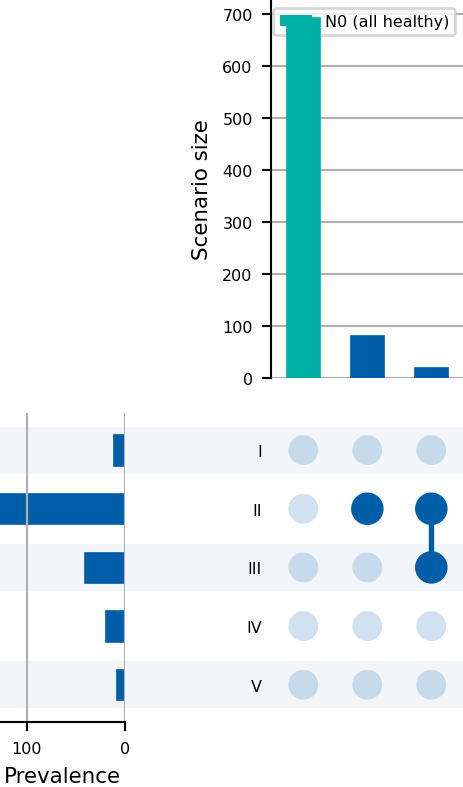

In [3]:
#| label: fig-data-upset-contra
#| fig-cap: 'Upset plot of the contralateral lymphatic involvement patterns [@lex_upset_2014]. Here, the horizontal bars depict the overall prevalence of LNL involvement. I.e., LNL II is the only level that is involved in more than 100 patients. The vertical bar plots depict joint involvements. E.g., the thirs bar from the left depicts how often the LNLs II, and III are jointly involved while level I, IV, and V are not. This is indicated by the light and dark shaded dots in the matrix underneath.'
from scripts import paths

axes = plot_involvement_upset(
  df=raw["max_llh", "contra"],
  lnls=[tpl[-1] for tpl in get_lnl_cols("contra")],
)

plt.savefig(paths.figure_dir / "fig-data-upset-contra.png", dpi=400)
plt.show()